In [72]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;
import pystan

In [73]:
data = pd.read_csv("trend2.csv")
data = data.dropna(axis = 0)
data = data.reset_index()
data = data.drop('index', axis=1)
data.head()

,country,year,church2,cc,gini_net,rgdpl
0,Australia,1965,26.182790,Australia,29.16514,15.23929
1,Australia,1967,24.744380,Australia,29.50664,16.25018
2,Australia,1979,4.442971,Australia,25.75894,21.58357
3,Australia,1981,27.626460,Australia,28.10000,22.46979
4,Australia,1984,18.099700,Australia,28.80875,23.45019


In [74]:
countries = data['country'].unique()
country_number = len(countries)
countryDict = dict(zip(countries, range(country_number)))
data['country_code'] = data.apply(lambda row: countryDict[row['country']], axis=1)

### Histogram of religiosity levels in log scale

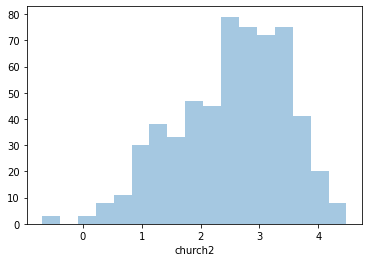

In [75]:
sns.distplot(np.log(data['church2']),kde = False)
plt.show()

In [76]:
country = data['country_code'] = data.country.replace(countryDict).values
log_religiosity = np.log(data.church2)
inequality = data.gini_net.values
rgdpl = data.rgdpl.values


In [77]:
partial_pooling = """
data {
  int<lower=0> N; 
  int<lower=1,upper=37> country[N];
  vector[N] y;
} 
parameters {
  vector[37] a;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = a[country[i]];
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal (10 * mu_a, sigma_a);
  y ~ normal(y_hat, sigma_y);
}"""

In [78]:
partial_pool_data = {'N': len(log_religiosity),
                   'country': country+1, # Stan counts starting at 1
                   'y': log_religiosity}


In [79]:
partial_pool_fit = pystan.stan(model_code=partial_pooling, data=partial_pool_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ce5f7bf87bce46f79e80b4acfb1757e8 NOW.


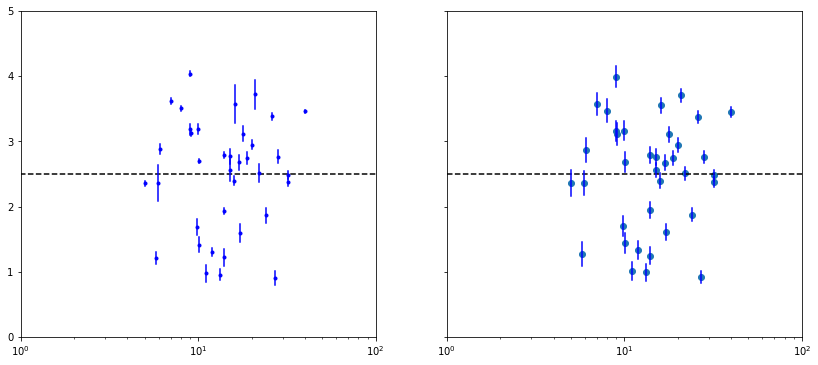

In [80]:
sample_trace = partial_pool_fit['a']

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
samples, numberOfCountries = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=numberOfCountries)
data['log_religiosity'] = data.apply(lambda row: np.log(row['church2']),axis=1)
n_country = data.groupby('country')['year'].count()
unpooled_means = data.groupby('country')['log_religiosity'].mean()
unpooled_sd = data.groupby('country')['log_religiosity'].std()
unpooled = pd.DataFrame({'n':n_country, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')

        
samples, numberOfCountries = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].scatter(n_country.values + jitter, means)
axes[1].set_xscale('log')
axes[1].set_xlim(1,100)
axes[1].set_ylim(0, 5)
axes[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
for j,n,m,s in zip(jitter, n_country.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-')

# Model With Variying Intercept

In [81]:


#varying intercept model
varying_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> country[N];
  vector[N] x1;
  vector[N] x2;
  vector[N] y;
} 
parameters {
  vector[J] a;
  real b1;
  real b2;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = a[country[i]] + x1[i] * b1 + x2[i] * b2;
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal (mu_a, sigma_a);
  b1 ~ normal (0, 1e5);
  b2 ~ normal (0, 1e5);
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [82]:
varying_intercept_data = {'N': len(log_religiosity),
                          'J': country_number,
                          'country': country+1,
                          'x1': inequality,
                          'x2': rgdpl,
                          'y': log_religiosity}

In [83]:
varying_intercept_fit = pystan.stan(model_code=varying_intercept, data=varying_intercept_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5349007592a482fa85902482bae35ca6 NOW.


In [84]:
a_sample = pd.DataFrame(varying_intercept_fit['a'])


/home/anilk/.local/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


<Figure size 432x1008 with 0 Axes>

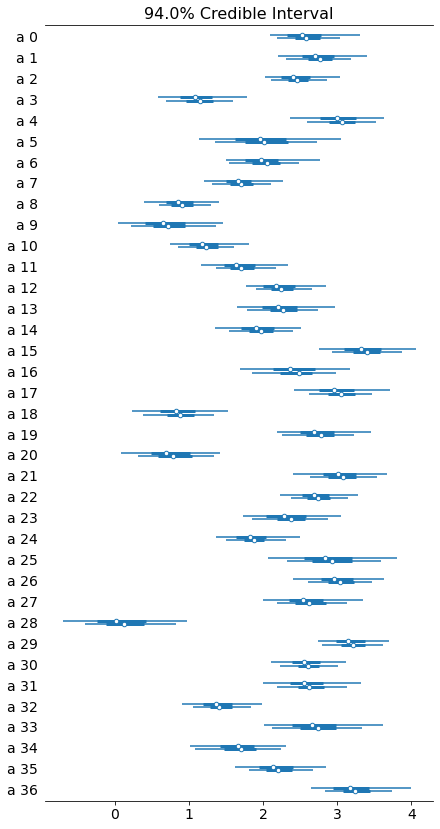

In [85]:
from pymc3 import forestplot, traceplot, plot_posterior
plt.figure(figsize=(6,14))
forestplot(varying_intercept_fit, varnames=['a']);



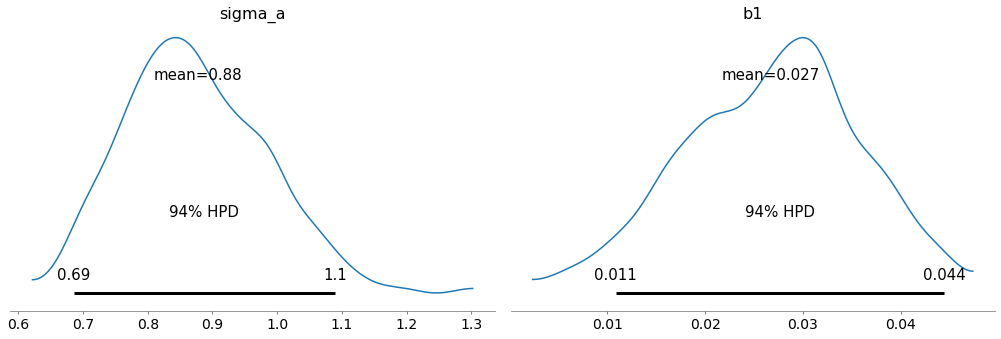

In [86]:
plot_posterior(varying_intercept_fit, varnames=['sigma_a', 'b1']);


In [87]:
from pymc3 import summary
summary(varying_intercept_fit, varnames=['b1'])

/home/anilk/.local/lib/python3.7/site-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b1,0.027,0.009,0.011,0.044,0.002,0.001,25.0,25.0,26.0,30.0,1.08


# Model with Informative Prior

In [88]:
prior_informative = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> country[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[J] a;
  real b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = a[country[i]] + x[i] * b;
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal (mu_a, sigma_a);
  b ~ normal (0.03, 1e-2);
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [89]:
prior_informative_data = {'N': len(log_religiosity),
                          'J': numberOfCountries,
                          'country': country+1, # Stan counts starting at 1
                          'x': inequality,
                          'y': log_religiosity}

prior_informative_fit = pystan.stan(model_code=prior_informative, data=prior_informative_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0401b7fc051eea3712a2365dd4b7fc6 NOW.


/home/anilk/.local/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


<Figure size 432x1008 with 0 Axes>

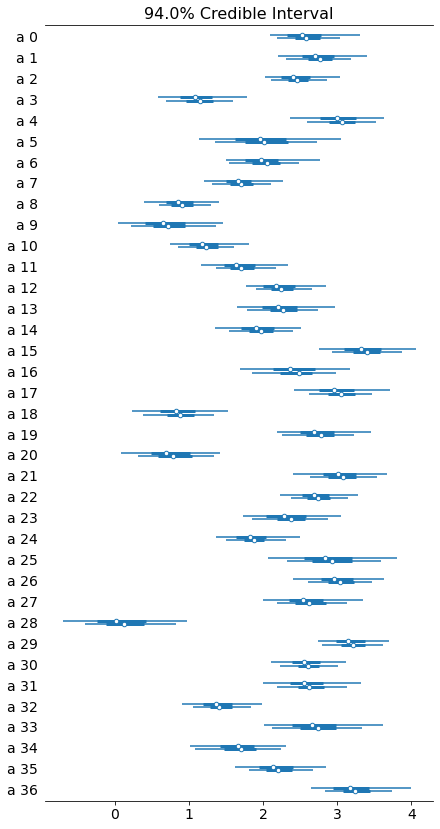

In [90]:
plt.figure(figsize=(6,14))
forestplot(varying_intercept_fit, varnames=['a']);

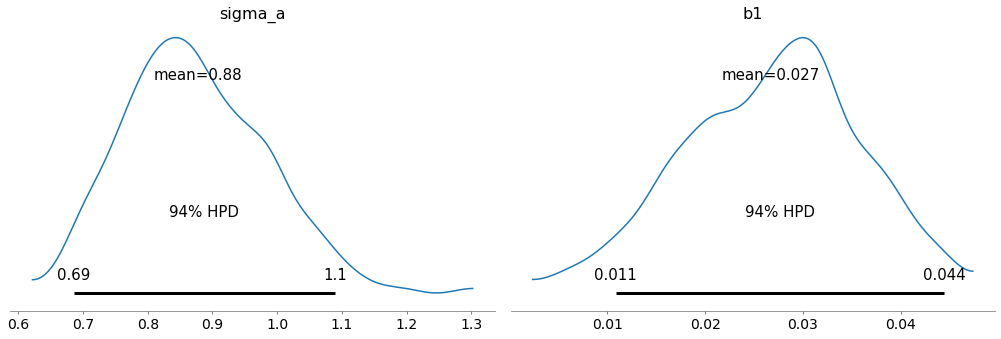

In [91]:
plot_posterior(varying_intercept_fit, varnames=['sigma_a', 'b1']);

In [93]:
summary(varying_intercept_fit, varnames=['b1'])

/home/anilk/.local/lib/python3.7/site-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b1,0.027,0.009,0.011,0.044,0.002,0.001,25.0,25.0,26.0,30.0,1.08


In uninformative model, the posterior  mostly affected by the data but in prior informative model, posterior is derived from both data and prior (beliefs). Since there is huge amount of data, it would dominate the posterior.